### Translation with Seq2Seq

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import time
import math
import random
import unicodedata
import re
import torch
import torch.nn
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

In [3]:
n_iters = 75000
learning_rate = 0.01
teacher_forcing_ratio = 0.5

file_name = 'data/eng-bel.txt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Data preparation and processing

In [4]:
SOS_token = 0
EOS_token = 1


class LanguageVocab(object):
    def __init__(self, name):

        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    s = re.sub(r"CC-BY .*", r" ", s)
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-ЯёЁ.!?]+", r" ", s)
    return s

In [6]:
def read_languages(lang1, lang2, reverse=False):
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
            read().strip().split('\n')

    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    # Remove the last empty string and filter pairs
    pairs = [[elem for elem in pair if elem != ''] for pair in pairs]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = LanguageVocab(lang2)
        output_lang = LanguageVocab(lang1)
    else:
        input_lang = LanguageVocab(lang1)
        output_lang = LanguageVocab(lang2)

    return input_lang, output_lang, pairs


def count_max_length(pairs):
    bel_row = []
    eng_row = []
    for i in range(len(pairs)):
        for pair in pairs:
            bel_length = len(pair[0].split(' '))
            eng_length = len(pair[0].split(' '))
            bel_row.append(bel_length)
            eng_row.append(eng_length)
    max_bel = max(bel_row)
    max_eng = max(eng_row)
    return max(max_bel, max_eng)

In [7]:
def prepare_data(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = read_languages(lang1, lang2, reverse)
    print("Number of sentence pairs: %s" % len(pairs))

    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

In [8]:
input_lang, output_lang, pairs = prepare_data('eng', 'bel', True)
print(random.choice(pairs))

max_length = count_max_length(pairs) + 1
print(f'The maximum length of phrases: {max_length}')

Number of sentence pairs: 3818
Counted words:
bel 4005
eng 2312
['мне трэба было штосьц зраб ць .', 'i should ve done something .']
The maximum length of phrases: 25


#### Encoder

In [9]:
class EncoderRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Decoder

In [10]:
class DecoderRNN(torch.nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = torch.nn.Embedding(output_size, hidden_size)
        self.gru = torch.nn.GRU(hidden_size, hidden_size)

        self.out = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [12]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, max_length=max_length):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    if use_teacher_forcing:
        # Teacher forcing: feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
                
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

In [13]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- eta: %s)' % (asMinutes(s), asMinutes(rs))

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=learning_rate):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = torch.nn.NLLLoss()

    for epoch in range(1, n_iters + 1):
        training_pair = training_pairs[epoch - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_iters),
                                         epoch, epoch / n_iters * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    show_plot(plot_losses)

0m 45s (- eta: 10m 30s) (5000 6%) 3.9774
1m 27s (- eta: 9m 27s) (10000 13%) 3.3546
2m 11s (- eta: 8m 44s) (15000 20%) 2.8826
2m 54s (- eta: 7m 59s) (20000 26%) 2.3963
3m 37s (- eta: 7m 14s) (25000 33%) 1.9061
4m 20s (- eta: 6m 31s) (30000 40%) 1.5039
5m 4s (- eta: 5m 47s) (35000 46%) 1.1838
5m 48s (- eta: 5m 5s) (40000 53%) 0.9457
6m 32s (- eta: 4m 21s) (45000 60%) 0.6941
7m 16s (- eta: 3m 38s) (50000 66%) 0.5348
8m 0s (- eta: 2m 54s) (55000 73%) 0.4082
8m 45s (- eta: 2m 11s) (60000 80%) 0.3089
9m 29s (- eta: 1m 27s) (65000 86%) 0.2232
10m 19s (- eta: 0m 44s) (70000 93%) 0.1756
11m 3s (- eta: 0m 0s) (75000 100%) 0.1349


<Figure size 432x288 with 0 Axes>

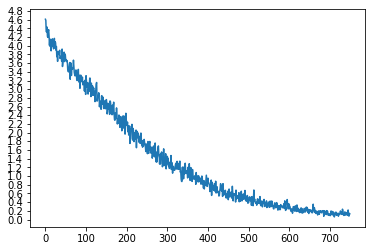

In [15]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
trainIters(encoder1, decoder1, n_iters, print_every=5000)

#### Evaluation

In [16]:
def evaluate(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for i in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
            encoder_outputs[i] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
        return decoded_words

In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    reference_corpus = []
    candidate_corpus = []

    for i in range(n):
        pair = random.choice(pairs)
        sentence = pair[0]
        translation = pair[1]
        print('>', sentence)
        print('=', translation)
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)

        # bleu score
        reference = translation.split()
        reference_corpus.append(reference)
        # remove <EOS> at the end
        candidate = [output_sentence.split()[:-1]]
        candidate_corpus.append(candidate)
        print('<', output_sentence)

    print('_' * 18)
    print('BLEU score: {:.4f}'.format(bleu_score(reference_corpus, candidate_corpus)))

In [18]:
evaluateRandomly(encoder1, decoder1)

> ты мая лепшая сяброука .
= you re my best friend .
< you are my best friend . <EOS>
> я даручыла ф нансы сям жонцы .
= i entrusted my wife with the family finances .
< i entrusted my wife with the family finances . <EOS>
> я люблю цемны шакалад .
= i like dark chocolate .
< i like dark chocolate . <EOS>
> гэта мои кот .
= that s my cat .
< this is my cat . <EOS>
> яна н кол не пападае па мячу .
= she is always missing the ball .
< she is always missing the ball . <EOS>
> гэта сапрауднае золата .
= that s real gold .
< that s real gold . <EOS>
> усе ведаюць што два плюс два чатыры .
= everybody knows that two and two make four .
< everybody knows that two and two make four . <EOS>
> ты не здагадауся закрыць вокны ?
= didn t it occur to you to shut the windows ?
< didn t it occur to you to shut the windows ? <EOS>
>  дз це за мнои .
= follow me .
< follow me . <EOS>
> дзе кот ?
= where is the cat ?
< where is the cat ? <EOS>
__________________
BLEU score: 0.9192
